In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM

# FOR REPRODUCIBILITY
np.random.seed(7)

In [ ]:
# IMPORTING DATASET
#data_path = 'https://www.cryptodatadownload.com/cdd/Binance_BTCUSDT_d.csv'
#data_path = 'https://www.cryptodatadownload.com/cdd/Bitfinex_BTCUSD_d.csv'
#data_path = 'https://www.cryptodatadownload.com/cdd/Bitfinex_BTCUSD_1h.csv'
data_path = 'https://www.cryptodatadownload.com/cdd/Bitfinex_ETHUSD_1h.csv'
trading_pair_0 = 'ETH'
trading_pair_1 = 'USD'
n_epochs = 5
batch_size = 1

#dataset = pd.read_csv('https://raw.githubusercontent.com/NourozR/Stock-Price-Prediction-LSTM/master/apple_share_price.csv', usecols=[1,2,3,4])
dataset = pd.read_csv(data_path, delimiter=',', skiprows=1)
dataset = dataset.drop(columns=['unix', 'symbol', 'Volume %s'%trading_pair_0, 'date', 'Volume %s'%trading_pair_1])#'tradecount' - for binance
dataset.rename(columns = {'open':'Open', 'high':'High', 'low':'Low', 'close':'Close'}, inplace = True)
dataset = dataset.reindex(index = dataset.index[::-1])

# CREATING OWN INDEX FOR FLEXIBILITY
obs = np.arange(1, len(dataset) + 1, 1)

# TAKING DIFFERENT INDICATORS FOR PREDICTION
OHLC_avg = dataset.mean(axis = 1)
HLC_avg = dataset[['High', 'Low', 'Close']].mean(axis = 1)
close_val = dataset[['Close']]

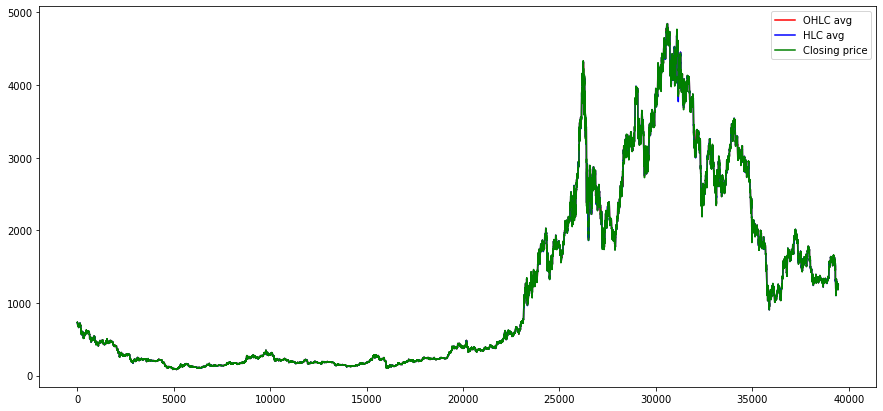

In [ ]:
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(7)
# PLOTTING ALL INDICATORS IN ONE PLOT
plt.plot(obs, OHLC_avg, 'r', label = 'OHLC avg')
plt.plot(obs, HLC_avg, 'b', label = 'HLC avg')
plt.plot(obs, close_val, 'g', label = 'Closing price')
plt.legend(loc = 'upper right')
plt.show()

In [ ]:
# FUNCTION TO CREATE 1D DATA INTO TIME SERIES DATASET
def new_dataset(dataset, step_size):
	data_X, data_Y = [], []
	for i in range(len(dataset)-step_size-1):
		a = dataset[i:i + step_size, 0]
		data_X.append(a)
		data_Y.append(dataset[i + step_size, 0])
	return (
          np.array(data_X), np.array(data_Y))

# THIS FUNCTION CAN BE USED TO CREATE A TIME SERIES DATASET FROM ANY 1D ARRAY	

In [ ]:
# PREPARATION OF TIME SERIES DATASE
OHLC_avg = np.reshape(OHLC_avg.values, (len(OHLC_avg),1)) # 1664
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(OHLC_avg)
OHLC_avg_norm = scaler.transform(OHLC_avg)

# TRAIN-TEST SPLIT
train_OHLC = int(len(OHLC_avg_norm) * 0.75)
test_OHLC = len(OHLC_avg_norm) - train_OHLC
train_OHLC, test_OHLC = OHLC_avg_norm[0:train_OHLC,:], OHLC_avg_norm[train_OHLC:len(OHLC_avg_norm),:]

# TIME-SERIES DATASET (FOR TIME T, VALUES FOR TIME T+1)
trainX, trainY = new_dataset(train_OHLC, 1)
testX, testY = new_dataset(test_OHLC, 1)

In [ ]:
# RESHAPING TRAIN AND TEST DATA
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
step_size = 1

# LSTM MODEL
model = Sequential()
model.add(LSTM(32, input_shape=(1, step_size), return_sequences = True))
#model.add(LSTM(32, return_sequences = True))#
#model.add(LSTM(64, return_sequences = True))#
model.add(LSTM(16))
model.add(Dense(1))
model.add(Activation('linear'))

# MODEL COMPILING AND TRAINING
model.compile(loss='mean_squared_error', optimizer='SGD') # Try SGD, adam, adagrad and compare!!!
model.fit(trainX, trainY, epochs=n_epochs, batch_size=batch_size, verbose=2)

Epoch 1/5
29592/29592 - 53s - loss: 0.0140 - 53s/epoch - 2ms/step
Epoch 2/5
29592/29592 - 43s - loss: 2.2721e-05 - 43s/epoch - 1ms/step
Epoch 3/5
29592/29592 - 46s - loss: 1.9029e-05 - 46s/epoch - 2ms/step
Epoch 4/5
29592/29592 - 44s - loss: 1.6401e-05 - 44s/epoch - 1ms/step
Epoch 5/5
29592/29592 - 43s - loss: 1.4386e-05 - 43s/epoch - 1ms/step


In [ ]:
# PREDICTION
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

309/309 [==============================] - 0s 1ms/step


In [ ]:
#print('train:', trainPredict[0:5])
#print('test:', testPredict[0:5])

In [ ]:
# DE-NORMALIZING FOR PLOTTING
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [ ]:
#print('trainPred:', trainPredict[0:5])
#print('trainY:', trainY[0][0:5])
#print('testPred:', testPredict[0:5])
#print('testY:', testY[0][0:5])

In [ ]:
# TRAINING RMSE
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train RMSE: %.2f' % (trainScore))

# TEST RMSE
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test RMSE: %.2f' % (testScore))

# CREATING SIMILAR DATASET TO PLOT TRAINING PREDICTIONS
trainPredictPlot = np.empty_like(OHLC_avg_norm)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[step_size:len(trainPredict)+step_size, :] = trainPredict

# CREATING SIMILAR DATASSET TO PLOT TEST PREDICTIONS
testPredictPlot = np.empty_like(OHLC_avg_norm)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(step_size*2)+1:len(OHLC_avg_norm)-1, :] = testPredict

# DE-NORMALIZING MAIN DATASET 
#OHLC_avg = scaler.inverse_transform(OHLC_avg_norm)

Train RMSE: 17.40
Test RMSE: 74.19


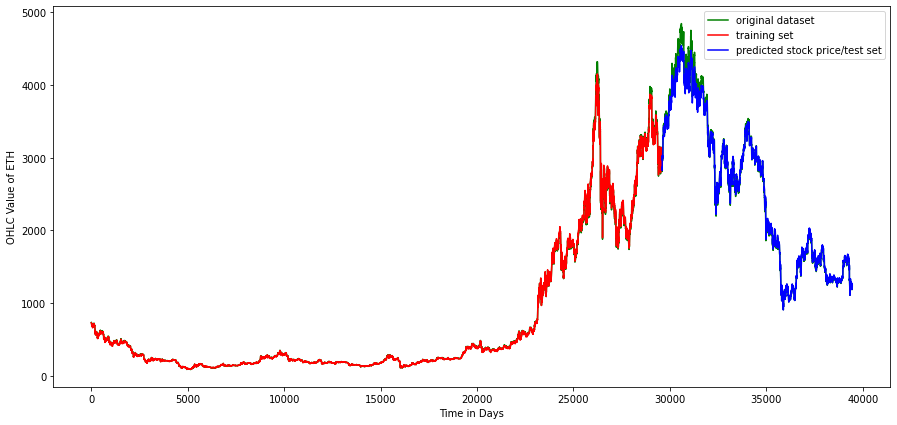

In [ ]:
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(7)
# PLOT OF MAIN OHLC VALUES, TRAIN PREDICTIONS AND TEST PREDICTIONS
plt.plot(OHLC_avg, 'g', label = 'original dataset')
plt.plot(trainPredictPlot, 'r', label = 'training set')
plt.plot(testPredictPlot, 'b', label = 'predicted stock price/test set')
plt.legend(loc = 'upper right')
plt.xlabel('Time in Days')
plt.ylabel('OHLC Value of %s'%trading_pair_0)
plt.show()

In [ ]:
# PREDICT FUTURE VALUES
last_val = testPredict[-1]
last_val_scaled = last_val/last_val
next_val = model.predict(np.reshape(last_val_scaled, (1,1,1)))
print("Last Day Value:", np.asscalar(last_val))
print("Next Day Value:", np.asscalar(last_val*next_val))
# print np.append(last_val, next_val)

1/1 [==============================] - 0s 18ms/step
Last Day Value: 1226.2760009765625
Next Day Value: 1148.581787109375


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
